In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from pathlib import Path
import warnings

import utils as optim
import optimization
import plotting

warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# import data
data_path = str(Path().absolute()) + "/data_will/48_industry_Portfolios.CSV"
df_global = pd.read_csv(data_path, index_col=0)
# df_global = df_global / 100
df_global.index = pd.to_datetime(df_global.index, format="%Y%m")  # clean the index to be datetime

# constants
start_date = "2019-12-01"  # 5 years worth of data (60 entries)
N = 48
risk_free = 0.4  # taken from Kenneth French Library
df_global = df_global.loc[df_global.index >= start_date, :]  # select last 5 years
df = df_global.loc[:, ["Whlsl", "Fin  ", "Util ", "Cnstr", "Hlth "]]  # select 5 assets to work with


# Question 1

Restricted license - for non-production use only - expires 2026-11-23


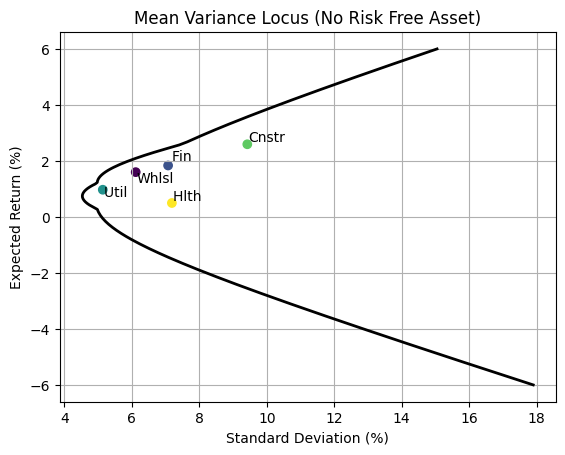

In [4]:
# first and second moment
cov = df.cov()
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))

# global mean variance portfolio
N = 5
init_w = np.repeat(1 / N, N)
target_returns = np.linspace(-6, 6, 225)

response_no_rf, weights = optim.mean_var_portfolio(df, target_returns, N)
plotting.mean_var_locus(response_no_rf[0], response_no_rf[1], std, mean, 'Mean Variance Locus (No Risk Free Asset)')


# Question 2

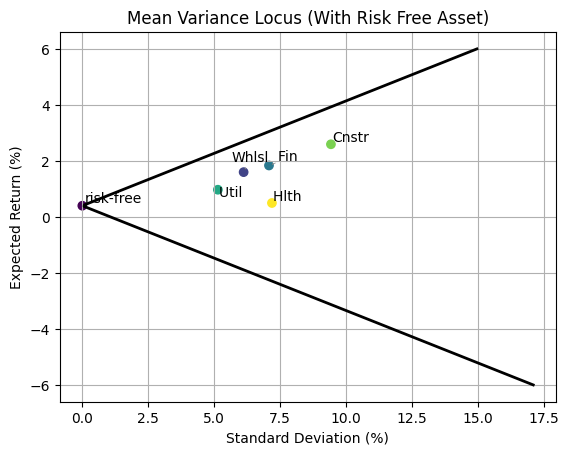

In [5]:
rf = pd.DataFrame(risk_free, index=df.index, columns=["risk-free"])
df_rf = pd.concat([rf, df], axis=1)

# cov = df.cov()
mean = df_rf.mean(axis=0)
std = np.sqrt(np.diag(df_rf.cov()))

response_rf, weights = optim.mean_var_portfolio(df_rf, target_returns, N, risk_free_asset= True)
plotting.mean_var_locus(response_rf[0], response_rf[1], std, mean, 'Mean Variance Locus (With Risk Free Asset)')


# Question 3

In [6]:
N = 6
rf = pd.DataFrame(risk_free, index=df.index, columns=["risk-free"])
df_rf = pd.concat([rf, df], axis=1)

# cov = df.cov()
mean = df_rf.mean(axis=0)
std = np.sqrt(np.diag(df_rf.cov()))
print(mean)
# global mean variance portfolio
target_returns = np.linspace(0, 50, 250)
sharpe = np.zeros(len(target_returns))

for i in range(len(target_returns)):
    SR, _, _ = optim.max_sharpe_ratio(df= df, exp_return= target_returns[i], K=3, long_only= False)
    sharpe[i] = SR

max = np.nanmax(sharpe)
idmax = np.nanargmax(sharpe)

SR, weights, positions = optim.max_sharpe_ratio(df= df, exp_return= target_returns[idmax], long_only= False)
weights

risk-free    0.400000
Whlsl        1.599667
Fin          1.837167
Util         0.971167
Cnstr        2.594833
Hlth         0.497500
dtype: float64


array([ 0.        ,  2.06764778,  0.        ,  3.13345453, -4.2011023 ])

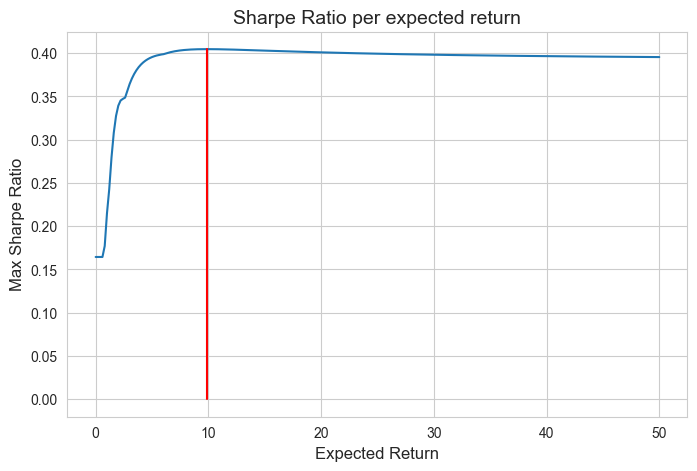

In [7]:
sns.set_style("whitegrid")

plt.figure(figsize=(8, 5))
sns.lineplot(y=sharpe, x= target_returns)
plt.plot([target_returns[idmax], target_returns[idmax]], [0, max], 'r-', linewidth=1.5, label="Threshold")
# Add Title and Labels
plt.title("Sharpe Ratio per expected return", fontsize=14)
plt.xlabel("Expected Return", fontsize=12)
plt.ylabel("Max Sharpe Ratio", fontsize=12)

# Show the Plot
plt.show()

In [8]:
def analytical_mean_var(mean: np.array, sigma: np.array, ret: float, rfr: float, n: int, risk_free_asset: bool,
                        tangent: bool):
    """
    minimizes variance of portfolio using analytical formulas
    :param mean: mean returns of each asset in portfolio
    :param sigma: variance-covariance matrix of portfolio of assets
    :param rfr: risk-free rate
    :param n: number of industries
    :param ret: the target return for the portfolio against which we minimize variance
    :param risk_free_asset: boolean determining whether there is a risk-free asset
    :param tangent: boolean to determine whether we want the tangency portfolio
    :return: standard deviation of portfolio
    """
    # use pseudo inverse due to numerical instability of covariance matrix
    # indeed the numerical instability is due to repeated samples causing the matrix to possess multi collinear columns
    # and thus to have a lower rank. This causes the determinant of the vcv matrix to approach zero and leads
    # to numerical instability. For the vcv to be invertible, the underlying matrices rank must be larger than
    # the number of columns, which is almost guaranteed to be false if we use 60 rows with resampling
    inv_sigma = np.linalg.pinv(sigma)
    a = np.ones(n).T @ inv_sigma @ np.ones(n)
    b = np.ones(n).T @ inv_sigma @ mean
    c = mean.T @ inv_sigma @ mean
    delta = a * c - b ** 2

    w = None
    w_rfr = None
    if (not risk_free_asset) and tangent:
        ValueError("Set risk-free asset to True to compute tangency portfolio")

    # weights with risk-free asset
    elif risk_free_asset and (not tangent):
        sharpe_sq = c - 2 * b * rfr + a * rfr ** 2
        w = ((ret - rfr) * inv_sigma @ (mean - rfr)) / sharpe_sq
        w_rfr = 1 - w.T @ np.ones(len(w))

    # tangency portfolio weights
    elif tangent:
        w = (inv_sigma @ (mean - rfr)) / (b - a * rfr)
        w_rfr = 0

    # weights without risk-free asset
    else:
        w = (c - ret * b) / delta * inv_sigma @ np.ones(n) + (ret * a - b) / delta * inv_sigma @ mean
        w_rfr = 0

    return w, w_rfr

In [9]:
from itertools import combinations

combination_list = list(combinations(df.columns, 1)) + list(combinations(df.columns, 2)) + list(combinations(df.columns, 3))

SR = 0
optim_w = np.zeros(3)
optim_cov = None
optim_mean = None

for comb in combination_list:
    temp_df = df.loc[:,comb]
    temp_cov = temp_df.cov()
    temp_mean = temp_df.mean(axis=0)

    response = optimization.tangency_portfolio(temp_df, 0.4, False)

    w = response.x
    var = w @ temp_cov @ w
    rets = temp_mean @ w
    temp = rets/np.sqrt(var)
    if SR < temp:
        SR = temp
        optim_w = w
        optim_cov = temp_cov
        optim_mean = temp_mean


analytical_w, _ = analytical_mean_var(optim_mean, optim_cov, 1, 0.4, 3, True, True)
print(f'analytical: {analytical_w}')
print(f'numerical: {optim_w}')

analytical: [  4.12735608   8.30124237 -11.42859846]
numerical: [  4.14535775   8.3346742  -11.48003195]


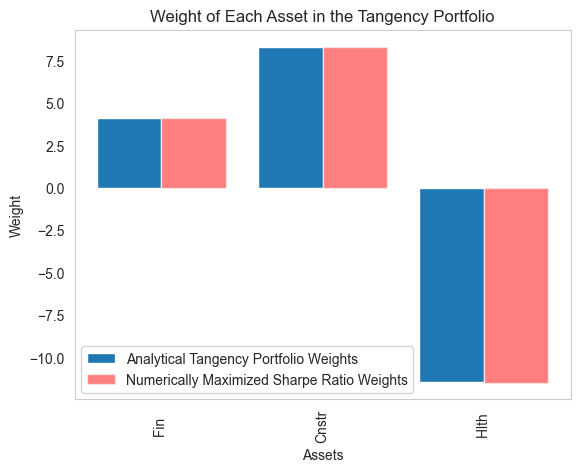

In [10]:
fig, ax = plt.subplots()
ax.grid()
x = np.arange(len(optim_mean))
width = 0.4

ax.bar(x= x - width/2, height= analytical_w, width= width, label="Analytical Tangency Portfolio Weights")
ax.bar(x= x + width/2, height= optim_w, width= width, alpha=0.5, color="red",
       label="Numerically Maximized Sharpe Ratio Weights")
ax.set_title("Weight of Each Asset in the Tangency Portfolio")
ax.set_xticks([0,1,2])
ax.set_xticklabels(optim_mean.index)
ax.set_xlabel("Assets")
ax.set_ylabel("Weight")
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Question 4

Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Unable to retrieve attribute 'ObjVal'
Error: Una

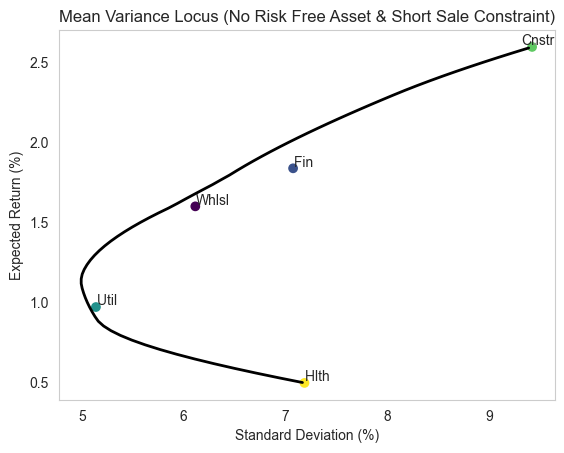

In [11]:
N = 5
cov = df.cov()
mean = df.mean(axis=0)
std = np.sqrt(np.diag(cov))

# global mean variance portfolio
target_returns = np.linspace(0, 6, 205)
x_no_rf = []
y_no_rf = []
for ret in target_returns:
    obj_val, weights = optim.minimize_variance_gurobi(mean, cov, ret, long_only= True)
    if obj_val is not None:
        x_no_rf.append(np.sqrt(obj_val))
        y_no_rf.append(mean @ weights)

# plot
plotting.mean_var_locus(x_no_rf, y_no_rf, std, mean, 'Mean Variance Locus (No Risk Free Asset & Short Sale Constraint)')

# Question 5

Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None
Error: Unable to retrieve attribute 'ObjVal'
None


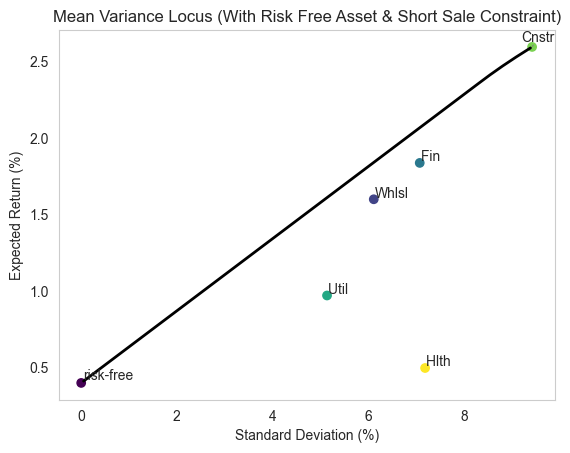

In [12]:
N = 6
rf = pd.DataFrame(risk_free, index=df.index, columns=["risk-free"])
df_rf = pd.concat([rf, df], axis=1)

cov = df_rf.cov()
mean = df_rf.mean(axis=0)
std = np.sqrt(np.diag(df_rf.cov()))

# global mean variance portfolio
target_returns = np.linspace(-6, 6, 205)
x_rf = []
y_rf = []
for ret in target_returns:
    obj_val, weights = optim.minimize_variance_gurobi(mean, cov, ret, risk_free_asset= True, long_only= True)
    print(obj_val)
    if obj_val is not None:
        x_rf.append(np.sqrt(obj_val))
        y_rf.append(mean @ weights)

# plot
plotting.mean_var_locus(x_rf, y_rf, std, mean, 'Mean Variance Locus (With Risk Free Asset & Short Sale Constraint)')

# Question 6

In [17]:
N = 6
rf = pd.DataFrame(risk_free, index=df.index, columns=["risk-free"])
df_rf = pd.concat([rf, df], axis=1)

cov = df.cov()
mean = df_rf.mean(axis=0)
std = np.sqrt(np.diag(df_rf.cov()))

from itertools import combinations

combination_list = list(combinations(df.columns, 1)) + list(combinations(df.columns, 2)) + list(combinations(df.columns, 3))

SR = 0
optim_w = np.zeros(3)
optim_cov = None
optim_mean = None

for comb in combination_list:
    temp_df = df.loc[:,comb]
    temp_cov = temp_df.cov()
    temp_mean = temp_df.mean(axis=0)

    response = optimization.tangency_portfolio(temp_df, 0.4, True)

    w = response.x
    var = w @ temp_cov @ w
    rets = temp_mean @ w
    temp = rets/np.sqrt(var)
    if SR < temp:
        SR = temp
        optim_w = w
        optim_cov = temp_cov
        optim_mean = temp_mean



[1.20185168e-17 2.85877596e-01 7.14122404e-01]
2.3782334077826692
8.395399103756667


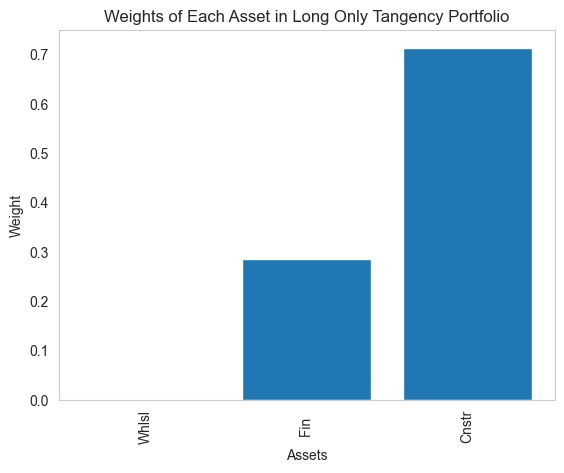

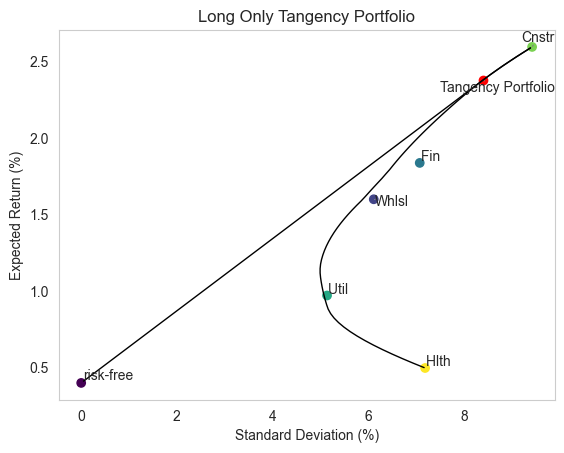

In [18]:
w = optim_w

print(w)
print(w @ optim_mean)
print(np.sqrt(w @ optim_cov @ w))

fig, ax = plt.subplots()
ax.bar(x= optim_mean.index, height=w)
ax.set_title("Weights of Each Asset in Long Only Tangency Portfolio")
ax.set_xlabel("Assets")
ax.set_ylabel("Weight")
ax.grid()
plt.xticks(rotation=90)
plt.show()

plotting.tangency_plot(x_rf, y_rf, x_no_rf, y_no_rf, w @ optim_mean, np.sqrt(w @ optim_cov @ w), std, mean,
                       "Long Only Tangency Portfolio")